In [ ]:
!unzip "/content/drive/MyDrive/humanface/human1024zip/03000-20210821T223453Z-001.zip" -d "/content/drive/MyDrive/humanface/human1024/"

Archive:  /content/drive/MyDrive/humanface/human1024zip/03000-20210821T223453Z-001.zip
  inflating: /content/drive/MyDrive/humanface/human1024/03000/03997.png  
  inflating: /content/drive/MyDrive/humanface/human1024/03000/03978.png  
  inflating: /content/drive/MyDrive/humanface/human1024/03000/03992.png  
  inflating: /content/drive/MyDrive/humanface/human1024/03000/03975.png  
  inflating: /content/drive/MyDrive/humanface/human1024/03000/03995.png  
  inflating: /content/drive/MyDrive/humanface/human1024/03000/03990.png  
  inflating: /content/drive/MyDrive/humanface/human1024/03000/03979.png  
  inflating: /content/drive/MyDrive/humanface/human1024/03000/03998.png  
  inflating: /content/drive/MyDrive/humanface/human1024/03000/03977.png  
  inflating: /content/drive/MyDrive/humanface/human1024/03000/03983.png  
  inflating: /content/drive/MyDrive/humanface/human1024/03000/03986.png  
  inflating: /content/drive/MyDrive/humanface/human1024/03000/03980.png  
  inflating: /content/dri

In [ ]:
# import shutil
# import os
# from tqdm import tqdm

# src = "/content/drive/MyDrive/humanface/human1024/03000"
# dest = "/content/drive/MyDrive/humanface/human1024"
# src_files = os.listdir(src)
# for file_name in tqdm(src_files):
#     full_file_name = os.path.join(src, file_name)
#     if os.path.isfile(full_file_name):
#         shutil.copy(full_file_name, dest)

100%|██████████| 1000/1000 [00:16<00:00, 59.30it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from tqdm import tqdm

In [ ]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	for filename in tqdm(listdir(path)):
		pixels = load_img(path + filename, target_size=size)
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

root_path = "/content/drive/MyDrive/"


In [ ]:
monkey_data = load_images(root_path + "allmonk/")
print('Loaded monkey: ', monkey_data.shape)

human_data = load_images(root_path + "humanface/human1024/")
print('Loaded monkey: ', human_data.shape)

100%|██████████| 203/203 [00:12<00:00, 16.14it/s]


Loaded monkey:  (203, 256, 256, 3)


100%|██████████| 4000/4000 [03:00<00:00, 22.16it/s]


Loaded monkey:  (4000, 256, 256, 3)


In [ ]:
from numpy import savez_compressed

filename = '/content/drive/MyDrive/monkey_cycleGAN/human2monkey_256.npz'
savez_compressed(filename, human_data, monkey_data)
print('Saved dataset: ', filename)

Saved dataset:  /content/drive/MyDrive/monkey_cycleGAN/human2monkey_256.npz


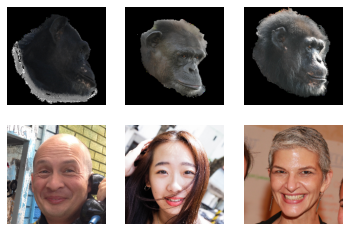

In [ ]:
# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot

# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(monkey_data[i].astype('uint8'))
 
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(human_data[i].astype('uint8'))
pyplot.show()

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-6668t0i3
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-6668t0i3
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101077 sha256=c73ca3daa6ccc05a5a1501942b437e2ec9ec4319b4417da57a9a1c77917f6ff1
  Stored in directory: /tmp/pip-ephem-wheel-cache-2_pil4gt/wheels/bb/1f/f2/b57495012683b6b20bbae94a3915ec79753111452d79886abc
Successfully built keras-contrib


In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

#discriminator model
def define_discriminator(image_shape):

	init = RandomNormal(stddev=0.02)

	in_image = Input(shape=image_shape)

	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)

	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	model = Model(in_image, patch_out)
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model



#standalone generator model
def define_generator(image_shape, n_resnet=9):

	init = RandomNormal(stddev=0.02)

	in_image = Input(shape=image_shape)

	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	for _ in range(n_resnet):
		g = resnet_block(256, g)

	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)

	model = Model(in_image, out_image)
	return model



In [ ]:
# generator a resnet block
def resnet_block(n_filters, input_layer):

	init = RandomNormal(stddev=0.02)

	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)

	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)

	g = Concatenate()([g, input_layer])
	return g

In [ ]:
#composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):

	g_model_1.trainable = True

	d_model.trainable = False

	g_model_2.trainable = False

	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)

	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)

	output_f = g_model_2(gen1_out)

	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)

	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])

	opt = Adam(lr=0.0002, beta_1=0.5)

	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [ ]:
# load and prepare training images
def load_real_samples(filename):

	data = load(filename)

	X1, X2 = data['arr_0'], data['arr_1']

	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):

	ix = randint(0, dataset.shape[0], n_samples)

	X = dataset[ix]

	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):

	X = g_model.predict(dataset)

	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = '/content/drive/MyDrive/monkey_cycleGAN/model/g_model_HtoM_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = '/content/drive/MyDrive/monkey_cycleGAN/model/g_model_MtoH_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))



In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	
	X_in, _ = generate_real_samples(trainX, n_samples, 0)

	X_out, _ = generate_fake_samples(g_model, X_in, 0)

	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0

	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])

	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])

	filename1 = '/content/drive/MyDrive/monkey_cycleGAN/result/%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

In [ ]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:

			pool.append(image)
			selected.append(image)
		elif random() < 0.5:

			selected.append(image)
		else:

			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [ ]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):

	n_epochs, n_batch, = 100, 1

	n_patch = d_model_A.output_shape[1]

	trainA, trainB = dataset

	poolA, poolB = list(), list()

	bat_per_epo = int(len(trainA) / n_batch)

	n_steps = bat_per_epo * n_epochs

	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if i % 2000 == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if i % 2000 == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

In [ ]:
from keras.models import load_model
# load image data
dataset = load_real_samples('/content/drive/MyDrive/monkey_cycleGAN/human2monkey_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: H -> M
# g_model_AtoB = define_generator(image_shape)
g_model_AtoB = load_model("/content/drive/MyDrive/monkey_cycleGAN/model/g_model_HtoM_008001.h5", {'InstanceNormalization': InstanceNormalization})
# generator: M -> H
# g_model_BtoA = define_generator(image_shape)
g_model_BtoA = load_model("/content/drive/MyDrive/monkey_cycleGAN/model/g_model_MtoH_008001.h5", {'InstanceNormalization': InstanceNormalization})
# discriminator: H -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: M -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: H -> M -> [real/fake, H]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: M -> H -> [real/fake, M]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

Loaded (4000, 256, 256, 3) (203, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Streaming output truncated to the last 5000 lines.
>57086, dA[0.006,0.019] dB[0.000,0.000] g[3.377,3.892]
>57087, dA[0.007,0.015] dB[0.000,0.000] g[2.642,2.877]
>57088, dA[0.048,0.005] dB[0.000,0.000] g[2.603,2.583]
>57089, dA[0.109,0.080] dB[0.000,0.000] g[2.488,2.617]
>57090, dA[0.005,0.004] dB[0.000,0.000] g[3.106,3.736]
>57091, dA[0.005,0.046] dB[0.000,0.000] g[3.222,3.361]
>57092, dA[0.009,0.012] dB[0.000,0.000] g[2.415,2.728]
>57093, dA[0.005,0.022] dB[0.000,0.000] g[2.006,2.079]
>57094, dA[0.006,0.010] dB[0.001,0.000] g[2.805,3.155]
>57095, dA[0.003,0.002] dB[0.000,0.000] g[2.820,3.495]
>57096, dA[0.006,0.007] dB[0.000,0.000] g[2.324,2.634]
>57097, dA[0.096,0.013] dB[0.000,0.000] g[2.063,2.238]
>57098, dA[0.058,0.016] dB[0.000,0.000] g[2.392,2.151]
>57099, dA[0.041,0.077] dB[0.001,0.000] g[2.139,1.805]
>57100, dA[0.031,0.003] dB[0.001,0.000] g[2.575,2.166]
>57101, dA[0.015,0.008] dB[0.001,0.000] g[2.937,2.624]
>57102, dA[0.011,0.011] dB[0.001,0.000] g[2.730,2.077]
>57103, dA[0.1